# Сбор фичей

Cобираем все данные (исходную таблицу и сгенерированные фичи) вместе и делим на тренировочную, валидационную и тестовую выборки в двух вариантах: со сбалансированными и несбалансированными классами

In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pymorphy2 import MorphAnalyzer
import nltk
from nltk.corpus import stopwords
import numpy as np

import re

In [134]:
data = "../data/wb_school_task_2.csv.gzip"
data = pd.read_csv(data, compression='gzip')
data = data.drop_duplicates(ignore_index=True)

In [135]:
data = data.drop(['f2', 'f4'], axis=1)

## Общие текстовые фичи

In [136]:
def extract_features(s: pd.Series):
    text = s['text']
    word_count = len(re.findall(r'[а-яА-Яa-zA-Z]+', text))
    # есть отзывы, состоящие из смайликов, пробелов или нижних подчеркиваний
    if word_count == 0:
            return pd.Series({
            'id1': s['id1'],
            'id2': s['id2'],
            'id3': s['id3'],
            'text': text,
            'label': s['label'],
            'text_len': len(text),
            'words_count': 0,
            'sentence_count': 0,
            'number_percentage': 0,
            'caps_percentage': 0,
            'is_empty': 1
        })

    return pd.Series({
        'id1': s['id1'],
        'id2': s['id2'],
        'id3': s['id3'],
        'text': text,
        'label': s['label'],
        'text_len': len(text),
        'words_count': word_count,
        'sentence_count': len(re.split(r'[.!?]+', text)),
        'number_percentage': len(re.findall(r'\d+', text)) / word_count,
        'caps_percentage': len(re.findall(r'[А-ЯA-Z]+', text)) / word_count,
        'is_empty': 0
    })

text_features = data.apply(extract_features, axis=1)
text_features

,id1,id2,id3,text,label,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",0,96,16,2,0.000000,0.062500,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,1,99,15,3,0.000000,0.266667,0
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",0,32,5,2,0.000000,0.200000,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",1,81,11,3,0.000000,0.181818,0
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,0,52,8,3,0.000000,0.375000,0
...,...,...,...,...,...,...,...,...,...,...,...
3117,764513678578182418,15635360211325277203,6836784353719029392,"Стекло не плохое,но есть один минус на техно с...",0,66,13,2,0.076923,0.076923,0
3118,6838893897482150395,13016265854619171030,12090430373311552618,"Всё пришло запаковано, ничего не сломано. Лучш...",0,63,10,2,0.000000,0.200000,0
3119,3080528623596565085,17787644417937804433,18003133089489520237,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",0,101,13,1,0.000000,0.076923,0
3120,13059704988549832630,997055248102065549,12214993272083833542,"Спасибо, целая пришла. Хорошо упаковано",0,40,5,2,0.000000,0.400000,0


In [137]:
merged_dataset = pd.merge(data, text_features, on=['text', 'label', 'id1', 'id2', 'id3'], how='left')
merged_dataset

,id1,id2,id3,text,f1,f3,f5,f6,f7,f8,label,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1.000000,13,4.272727,18,36,0,96,16,2,0.000000,0.062500,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,2.700000,4,4.434783,90,109,1,99,15,3,0.000000,0.266667,0
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4.000000,0,4.500000,4,6,0,32,5,2,0.000000,0.200000,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,5.000000,30,4.772727,14,15,1,81,11,3,0.000000,0.181818,0
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,5.000000,4,5.000000,26,33,0,52,8,3,0.000000,0.375000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,764513678578182418,15635360211325277203,6836784353719029392,"Стекло не плохое,но есть один минус на техно с...",2,3.000000,1,4.263158,9,9,0,66,13,2,0.076923,0.076923,0
3118,6838893897482150395,13016265854619171030,12090430373311552618,"Всё пришло запаковано, ничего не сломано. Лучш...",8,4.375000,83,4.183206,18,18,0,63,10,2,0.000000,0.200000,0
3119,3080528623596565085,17787644417937804433,18003133089489520237,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",13,5.000000,2,4.944828,12,14,0,101,13,1,0.000000,0.076923,0
3120,13059704988549832630,997055248102065549,12214993272083833542,"Спасибо, целая пришла. Хорошо упаковано",3,5.000000,19,4.648780,103,155,0,40,5,2,0.000000,0.400000,0


## Фичи из ID

In [138]:
def id_analize(id_col: str, data: pd.DataFrame):
    df = data[[id_col, "label"]]
    df = df.groupby(by=id_col)
    col0 = id_col + "_0"
    col1 = id_col + "_1"
    result = pd.DataFrame(data = {id_col: data[id_col].unique()}, columns=[id_col, col0, col1])
    for idn, table in df:
        if table.shape[0] < 3: 
            result.loc[result[id_col]==idn, col0] = 0
            result.loc[result[id_col]==idn, col1] = 0
            continue
        result.loc[result[id_col]==idn, col0] = (table['label'] == 0).sum()/table.shape[0]
        result.loc[result[id_col]==idn, col1] = (table['label'] == 1).sum()/table.shape[0]
    return result


#for col in ['id1', 'id2']:
    #id_analized = id_analize(col, data)
    #id_analized.to_csv(f"./{col}_data.csv", index=False)
    #merged_dataset = merged_dataset.merge(id_analized, how='left', on=col)

In [139]:
def id_analize2(id_col: str, data: pd.DataFrame):
    df = data[[id_col, "label"]]
    df = df.groupby(by=id_col)
    col0 = id_col+"_pred"
    col1 = id_col+"_in_database"
    result = pd.DataFrame(data = {id_col: data[id_col].unique()}, columns=[id_col, col0, col1])
    for idn, table in df:
        if table.shape[0] < 3: 
            result.loc[result[id_col]==idn, col0] = 0
            result.loc[result[id_col]==idn, col1] = 0
            continue
        result.loc[result[id_col]==idn, col0] = (table['label'] == 1).sum()/table.shape[0]
        result.loc[result[id_col]==idn, col1] = 1
    return result


for col in ['id1', 'id2']:
    id_analized = id_analize2(col, data)
    id_analized.to_csv(f"./{col}_data.csv", index=False)
    merged_dataset = merged_dataset.merge(id_analized, how='left', on=col)

In [141]:
id_analized[id_analized['id2_in_database'] == 0]

,id2,id2_pred,id2_in_database
0,173777575861152844,0,0
1,14366783259208998381,0,0
2,16985421652518589249,0,0
3,2629180387521298831,0,0
4,14531191561111600318,0,0
...,...,...,...
3001,15635360211325277203,0,0
3002,13016265854619171030,0,0
3003,17787644417937804433,0,0
3004,997055248102065549,0,0


In [142]:
merged_dataset.head()

,id1,id2,id3,text,f1,f3,f5,f6,f7,f8,...,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty,id1_pred,id1_in_database,id2_pred,id2_in_database
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1.0,13,4.272727,18,36,...,96,16,2,0.0,0.062500,0,0,0,0,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,2.7,4,4.434783,90,109,...,99,15,3,0.0,0.266667,0,0,0,0,0
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4.0,0,4.500000,4,6,...,32,5,2,0.0,0.200000,0,0,0,0,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,5.0,30,4.772727,14,15,...,81,11,3,0.0,0.181818,0,0,0,0,0
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,5.0,4,5.000000,26,33,...,52,8,3,0.0,0.375000,0,0,0,0,0


## Классификация текстов

Вместо того, чтобы конкатенировать векторизированные слова вместе с основными фичами, просто сделаем отдельную классификацию текстов

In [143]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, KeyedVectors

from navec import Navec

navec = Navec.load("../model/navec_hudlit_v1_12B_500K_300d_100q.tar")

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

In [144]:
import pickle
with open("../model/text_cl.pkl", 'rb') as f:
    text_classifier = pickle.load(f) 

with open("../model/tf_idf.pkl", 'rb') as f:
    tf_idf = pickle.load(f)

In [145]:
def text_classification(doc):
    local_falls = 0
    doc = re.sub(patterns, ' ', doc)
    vector = tf_idf.transform([doc])
    proba = text_classifier.predict_proba(vector)[0]
    for token in doc.split():
        token = re.sub("[^А-Яа-я]", '', token)
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            try:
                navec[token]
            except:
                local_falls += 1
    return *proba, local_falls

vector_data = data.apply(lambda x: text_classification(x['text']), axis=1)

In [146]:
vector_data.head()

0     (0.4412327999466402, 0.5587672000533598, 2)
1    (0.48205227866352807, 0.5179477213364719, 1)
2     (0.5875346499393287, 0.4124653500606713, 1)
3     (0.4951146734684083, 0.5048853265315917, 0)
4    (0.5327510653776146, 0.46724893462238537, 0)
dtype: object

In [147]:
text_data = vector_data.apply(lambda x: pd.Series(x, index=['text_0', 'text_1', 'falls_count']))

In [148]:
text_data.head()

,text_0,text_1,falls_count
0,0.441233,0.558767,2.0
1,0.482052,0.517948,1.0
2,0.587535,0.412465,1.0
3,0.495115,0.504885,0.0
4,0.532751,0.467249,0.0


In [149]:
full_data = merged_dataset.merge(text_data, left_index=True, right_index=True)

In [150]:
full_data.head()

,id1,id2,id3,text,f1,f3,f5,f6,f7,f8,...,number_percentage,caps_percentage,is_empty,id1_pred,id1_in_database,id2_pred,id2_in_database,text_0,text_1,falls_count
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1.0,13,4.272727,18,36,...,0.0,0.062500,0,0,0,0,0,0.441233,0.558767,2.0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,2.7,4,4.434783,90,109,...,0.0,0.266667,0,0,0,0,0,0.482052,0.517948,1.0
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4.0,0,4.500000,4,6,...,0.0,0.200000,0,0,0,0,0,0.587535,0.412465,1.0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,5.0,30,4.772727,14,15,...,0.0,0.181818,0,0,0,0,0,0.495115,0.504885,0.0
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,5.0,4,5.000000,26,33,...,0.0,0.375000,0,0,0,0,0,0.532751,0.467249,0.0


In [151]:
full_data.to_csv("./unbalanced_data/full_data.csv", index=False)

# Разделение данных

In [152]:
X_train, X_test = train_test_split(full_data, test_size=0.2, stratify=full_data['label'])
len(X_train), len(X_test)

(2497, 625)

In [153]:
X_train, X_valid = train_test_split(X_train, test_size=0.2, stratify=X_train['label'])
len(X_train), len(X_valid)

(1997, 500)

In [154]:
X_train.to_csv('./unbalanced_data/train_data.csv', index=False)
X_test.to_csv('./unbalanced_data/test_data.csv', index=False)
X_valid.to_csv('./unbalanced_data/valid_data.csv', index=False)

### Сбалансированные классы

In [155]:
(X_train['label']==1).sum()

528

In [156]:
cutted_x = X_train.sort_values(by='label', ascending=False, ignore_index=True).loc[:(X_train['label']==1).sum()*2]
cutted_x = cutted_x.sample(frac=1).reset_index(drop=True)
cutted_x.to_csv('./cutted_data/train_data.csv', index=False)

In [157]:
cutted_x = X_valid.sort_values(by='label', ascending=False, ignore_index=True).loc[:(X_valid['label']==1).sum()*2]
cutted_x = cutted_x.sample(frac=1).reset_index(drop=True)
cutted_x.to_csv('./cutted_data/valid_data.csv', index=False)

In [158]:
cutted_x = X_test.sort_values(by='label', ascending=False, ignore_index=True).loc[:(X_test['label']==1).sum()*2]
cutted_x = cutted_x.sample(frac=1).reset_index(drop=True)
cutted_x.to_csv('./cutted_data/test_data.csv', index=False)

# CatBoost

In [451]:
from catboost import CatBoostClassifier
import optuna
import pandas as pd
from sklearn.metrics import f1_score, recall_score, precision_score

In [452]:
data_train = pd.read_csv('./unbalanced_data/train_data.csv')
Y_train = data_train['label']
X_train = data_train.drop(['label', 'id1', 'id2', 'id3', 'text'], axis=1)
len(X_train)

1997

In [453]:
X_train.head()

,f1,f3,f5,f6,f7,f8,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty,id1_pred,id1_in_database,id2_pred,id2_in_database,text_0,text_1,falls_count
0,4,2.750000,3,5.000000,7,8,96,16,5,0.0,0.250000,0,0.0,0,0.000000,0,0.469859,0.530141,1.0
1,37,4.945946,3070,4.157873,71,74,81,12,5,0.0,0.333333,0,0.0,0,0.666667,1,0.560994,0.439006,0.0
2,3,5.000000,907,4.751469,12,15,49,7,1,0.0,0.142857,0,0.0,0,0.000000,0,0.596021,0.403979,0.0
3,530,4.349057,0,5.000000,873,2123,87,13,4,0.0,0.307692,0,1.0,1,0.000000,0,0.436426,0.563574,1.0
4,55,4.600000,217,4.380795,156,980,21,3,3,0.0,0.666667,0,0.0,0,0.000000,0,0.604840,0.395160,0.0


In [454]:
cl_train_0 = sum(Y_train==0)
cl_train_1 = sum(Y_train==1)
sum(Y_train==1), sum(Y_train==0)

(528, 1469)

In [455]:
data_valid = pd.read_csv('./unbalanced_data/valid_data.csv')
Y_valid = data_valid['label']
X_valid = data_valid.drop(['label', 'id1', 'id2', 'id3', 'text'], axis=1)
len(X_valid)

500

In [456]:
X_valid.head()

,f1,f3,f5,f6,f7,f8,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty,id1_pred,id1_in_database,id2_pred,id2_in_database,text_0,text_1,falls_count
0,1,1.000000,17,4.651316,2,6,175,28,7,0.000000,0.214286,0,0.0,0,0.0,0,0.435405,0.564595,2.0
1,2,4.000000,2,5.000000,4,7,917,133,7,0.135338,0.105263,0,0.0,0,0.0,0,0.488095,0.511905,3.0
2,1,5.000000,34,4.651786,1,3,55,10,1,0.100000,0.100000,0,0.0,0,0.0,0,0.454640,0.545360,1.0
3,19,4.894737,26,4.821429,51,124,240,41,5,0.024390,0.097561,0,0.0,0,0.0,0,0.475857,0.524143,0.0
4,2,5.000000,149,4.816749,2,2,87,12,1,0.000000,0.083333,0,0.0,0,0.0,0,0.529561,0.470439,0.0


In [457]:
sum(Y_valid==1), sum(Y_valid==0)

(132, 368)

In [477]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 90, 150),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1),
        depth=trial.suggest_int("depth", 10, 20),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0),
        eval_metric='F1',
        class_weights=(cl_train_1, cl_train_0),
        verbose=False,
        random_state = 42,
        thread_count=-1
    )
    model.fit(X_train, Y_train,
              verbose=False)
    pred = model.predict(X_valid)
    return f1_score(Y_valid, pred, average='weighted')

In [ ]:
study = optuna.create_study(direction='maximize', study_name='classifier_CatBoost')
study.optimize(objective, n_trials=30)

In [462]:
study.best_params

{'iterations': 96,
 'learning_rate': 0.09975268746932525,
 'depth': 15,
 'l2_leaf_reg': 0.5908593533847338,
 'random_strength': 4.264579397542064}

In [463]:
params = {'iterations': 96,
 'learning_rate': 0.09975268746932525,
 'depth': 15,
 'l2_leaf_reg': 0.5908593533847338,
 'random_strength': 4.264579397542064}

In [464]:
X_train.columns

Index(['f1', 'f3', 'f5', 'f6', 'f7', 'f8', 'text_len', 'words_count',
       'sentence_count', 'number_percentage', 'caps_percentage', 'is_empty',
       'id1_pred', 'id1_in_database', 'id2_pred', 'id2_in_database', 'text_0',
       'text_1', 'falls_count'],
      dtype='object')

In [465]:
model = CatBoostClassifier(**params,
                           random_state = 42, 
                           thread_count=-1,
                           class_weights=(cl_train_1, cl_train_0),
                           eval_metric = 'F1',
                           custom_metric='F1')

In [466]:
model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

0:	learn: 0.7429699	test: 0.6946209	best: 0.6946209 (0)	total: 7.12s	remaining: 11m 16s
1:	learn: 0.7137455	test: 0.7315910	best: 0.7315910 (1)	total: 7.27s	remaining: 5m 41s
2:	learn: 0.7111108	test: 0.7340324	best: 0.7340324 (2)	total: 7.42s	remaining: 3m 50s
3:	learn: 0.7040654	test: 0.7350750	best: 0.7350750 (3)	total: 7.49s	remaining: 2m 52s
4:	learn: 0.7229714	test: 0.7228403	best: 0.7350750 (3)	total: 13.2s	remaining: 4m
5:	learn: 0.7406288	test: 0.7178032	best: 0.7350750 (3)	total: 18.3s	remaining: 4m 35s
6:	learn: 0.7590570	test: 0.7327966	best: 0.7350750 (3)	total: 23.1s	remaining: 4m 54s
7:	learn: 0.7415551	test: 0.7259153	best: 0.7350750 (3)	total: 27.9s	remaining: 5m 6s
8:	learn: 0.7459693	test: 0.7218211	best: 0.7350750 (3)	total: 27.9s	remaining: 4m 29s
9:	learn: 0.7550532	test: 0.7177728	best: 0.7350750 (3)	total: 29.1s	remaining: 4m 10s
10:	learn: 0.7689087	test: 0.7147662	best: 0.7350750 (3)	total: 33.7s	remaining: 4m 20s
11:	learn: 0.7693655	test: 0.7208047	best: 0.7

In [467]:
model.best_score_

{'learn': {'F1:use_weights=false': 0.8680248007085917,
  'Logloss': 0.278121290977475,
  'F1': 0.9263665905215405,
  'F1:use_weights=true': 0.9263665905215405},
 'validation': {'F1:use_weights=false': 0.6180555555555556,
  'Logloss': 0.5402830474707951,
  'F1': 0.7395148349746721,
  'F1:use_weights=true': 0.7395148349746721}}

In [468]:
data_test = pd.read_csv('./unbalanced_data/test_data.csv')
Y_test = data_test['label']
X_test = data_test.drop(['label', 'id1', 'id2', 'id3', 'text'], axis=1)

In [469]:
model.score(X_train, Y_train)

0.8222333500250375

In [470]:
model.score(X_valid, Y_valid)

0.752

In [471]:
model.score(X_test, Y_test)

0.7376

In [473]:
f1_score(Y_test, model.predict(X_test), average='weighted')

0.7501555602368748

In [474]:
model.get_evals_result()['validation']['F1'][-1]

0.7136672144030863

In [475]:
model.predict(X_test.loc[30:45]), Y_test.loc[30:45].to_numpy()

(array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], dtype=int64))

In [476]:
# рассмотрим конкретно малочисленный класс
mask = Y_test==1
model.predict(X_test.loc[mask])[:20]

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
      dtype=int64)

In [401]:
model.save_model("../model/catboost_with_id.model")

In [311]:
feature_importance = {}
for name, val in zip(X_train.columns, model.get_feature_importance()):
    feature_importance[name] = val

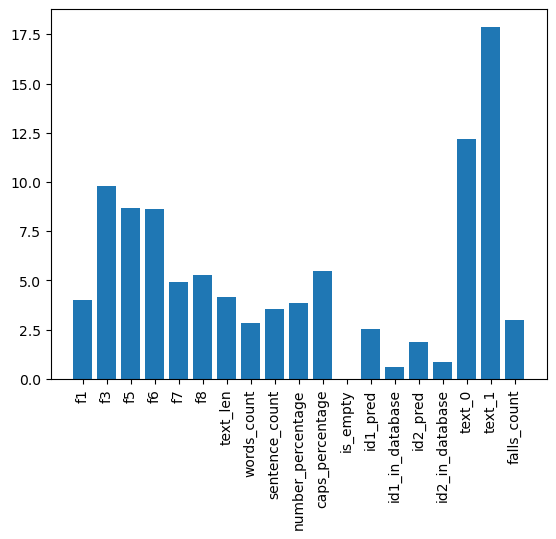

In [312]:
plt.bar(feature_importance.keys(), feature_importance.values())
plt.xticks(rotation=90)
plt.show()